In [1]:

import numpy as np
import pandas as pd
%matplotlib inline
import glob
import keras
from functools import reduce


Using TensorFlow backend.


In [2]:
path = r'/Users/mahnooshsadeghi/Desktop/PTSD/PTSD Data/Kalman Imputed Data' # use your path
all_files = glob.glob(path + "/*.csv")

In [3]:
participant=1
li=[]

In [4]:
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    l=df.index[df['ptsd_moment'] == 'STRESSMOMENT'].tolist()
    for i in l:
        df.ptsd_moment[i-30: i+30]= 'STRESSMOMENT'
    #df['participant']=participant
    df['windowno']= -1
    j=0
    k=1
    while j<len(df.index)-59:
        df['windowno'][j:j+60]=k
        j=j+60
        k=k+1
    df1=df.dropna(axis=0, subset=['hr'])
    df1 = df1.reset_index(drop=True)
    count =  df1.groupby('windowno', as_index=False)['hr'].size()
    for i in df1.windowno:
        if count[i]<40:
            df1=df1[df1.windowno != i ]
    df1.loc[df1.ptsd_moment != 'STRESSMOMENT', 'ptsd_moment'] = 0
    df1.loc[df1.ptsd_moment == 'STRESSMOMENT', 'ptsd_moment'] = 1
    hrmean=df1.groupby('windowno', as_index=False)['hr'].mean()
    hrmean=hrmean.rename(columns={"hr": "hrmean"})
    hrsd=df1.groupby('windowno').agg(np.std,ddof=0)['hr']
    hrsd=pd.DataFrame(hrsd)
    hrsd=hrsd.rename(columns={"hr": "hrsd"})
    stress=df1.groupby('windowno', as_index=False)['ptsd_moment'].max()
    hrmin=df1.groupby('windowno', as_index=False)['hr'].min()
    hrmin=hrmin.rename(columns={"hr": "hrmin"})
    hrmax=df1.groupby('windowno', as_index=False)['hr'].max()
    hrmax=hrmax.rename(columns={"hr": "hrmax"})
    linaccx=df1.groupby('windowno', as_index=False)['linear_accel_x'].mean()
    linaccy=df1.groupby('windowno', as_index=False)['linear_accel_y'].mean()
    linaccz=df1.groupby('windowno', as_index=False)['linear_accel_z'].mean()
    acc_x=df1.groupby('windowno', as_index=False)['acc_x'].mean()
    acc_y=df1.groupby('windowno', as_index=False)['acc_y'].mean()
    acc_z=df1.groupby('windowno', as_index=False)['acc_z'].mean()
    data=reduce(lambda x,y: pd.merge(x,y, on='windowno', how='outer'),
       [hrmean,hrmin,hrmax,hrsd,linaccx,linaccy,linaccz,acc_x,acc_y,acc_z,stress])
    data['participant']=participant
    participant=participant+1
    li.append(data)

frame = pd.concat(li, axis=0, ignore_index=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.

In [46]:
frame.ptsd_moment.value_counts()


0.0    12832
1.0      512
Name: ptsd_moment, dtype: int64

In [47]:
frame.participant.value_counts()


2     955
10    827
71    590
27    573
65    569
48    480
78    477
38    456
47    435
8     394
55    356
83    317
68    283
25    259
62    254
28    215
86    202
21    198
45    197
74    184
81    174
85    168
58    161
87    160
16    156
37    156
12    155
9     150
79    150
11    148
     ... 
72     52
50     52
33     47
64     46
4      45
36     44
49     44
69     43
76     43
75     43
46     40
59     39
30     38
41     38
44     36
26     36
17     32
13     30
20     29
63     27
77     26
73     24
51     21
80     16
32     15
19     14
67     14
14     12
53     10
52      8
Name: participant, Length: 87, dtype: int64

In [48]:
frame['hrrange']= frame['hrmax']-frame['hrmin']

In [49]:
frame ['linacc']= (frame['linear_accel_x']**2+frame['linear_accel_y']**2+frame['linear_accel_z']**2)**0.5

In [50]:
export_csv = frame.to_csv (r'/Users/mahnooshsadeghi/Desktop/PTSD/PTSD Data/export_dataframe.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path



In [51]:
# Divide by class
frame0 = frame[frame['ptsd_moment'] ==0]
frame1 = frame[frame['ptsd_moment'] == 1]


In [52]:
count_class_0, count_class_1 = frame.ptsd_moment.value_counts()

In [53]:
count_class_1

512

In [54]:
frame0under = frame0.sample(3*count_class_1)
frameunder = pd.concat([frame0under, frame1], axis=0)

In [55]:
X= frameunder[['acc_x','acc_y','acc_z','linear_accel_x','linear_accel_y',
      'linear_accel_z','linacc','hrmax', 'hrmean','hrmin','hrrange','hrsd']]
#X= frameunder[['linacc','hrmax', 'hrmean','hrmin','hrrange','hrsd']]
y= frameunder[['ptsd_moment']]

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [150]:
import xgboost

In [151]:
from xgboost import XGBClassifier

In [174]:
clf= XGBClassifier ()

In [175]:
clf.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [176]:
from sklearn import metrics


predictions=clf.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))

[[434  29]
 [109  42]]


In [177]:
Confusion = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), 
                         index=['NO PTSD','PTSD'], 
                         columns=['NO PTSD','PTSD'])
Confusion

accuracy = accuracy_score(y_test, predictions)
accuracy

0.7752442996742671

In [178]:
from sklearn.metrics import auc

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=2)


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [179]:
y_preds = clf.predict_proba(X_test)

# take the second column because the classifier outputs scores for
# the 0 class as well
preds = y_preds[:,1]
import matplotlib.pyplot as plt


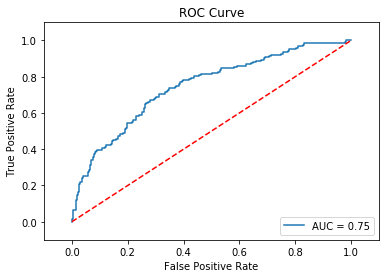

In [180]:
# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

In [129]:
frame

In [130]:
#df1

In [159]:
#dropping missing values in frame 1 to avoid bias: Just one window from the PTSD moments are dropped

frame_no_missing = frame.dropna()

In [160]:
frame_no_missing .ptsd_moment.value_counts()

0.0    12798
1.0      511
Name: ptsd_moment, dtype: int64

In [161]:
frame_no_missing0 = frame_no_missing[frame_no_missing['ptsd_moment'] ==0]
frame_no_missing1 = frame_no_missing[frame_no_missing['ptsd_moment'] == 1]

In [162]:
count_class_0, count_class_1 = frame_no_missing.ptsd_moment.value_counts()

In [163]:
count_class_1

511

In [164]:
frame0under = frame_no_missing0.sample(3*count_class_1)
frameunder = pd.concat([frame0under, frame_no_missing1], axis=0)

In [165]:
X= frameunder[['acc_x','acc_y','acc_z','linear_accel_x','linear_accel_y',
      'linear_accel_z','linacc','hrmax', 'hrmean','hrmin','hrrange','hrsd']]
#X= frameunder[['linacc','hrmax', 'hrmean','hrmin','hrrange','hrsd']]
y= frameunder[['ptsd_moment']]

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [188]:
#######SVM
from sklearn.svm import SVC

svc_model=SVC(probability=True, random_state=10)


In [189]:
svc_model.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=10,
  shrinking=True, tol=0.001, verbose=False)

In [190]:
predictions=svc_model.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))

[[450  13]
 [132  19]]


In [191]:
Confusion = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), 
                         index=['NO PTSD','PTSD'], 
                         columns=['NO PTSD','PTSD'])
Confusion

accuracy = accuracy_score(y_test, predictions)
accuracy

0.7638436482084691

In [192]:
from sklearn.metrics import auc

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=2)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [193]:
y_preds = svc_model.predict_proba(X_test)

# take the second column because the classifier outputs scores for
# the 0 class as well
preds = y_preds[:,1]
import matplotlib.pyplot as plt

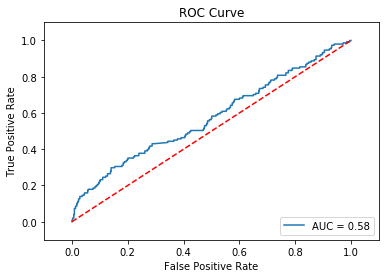

In [194]:
# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

In [181]:
###Logistic regression for windows


from sklearn.linear_model import LogisticRegression
lr_model= LogisticRegression(solver='lbfgs')
lr_model.fit(X_train,y_train)

from sklearn import metrics
predictions=lr_model.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))

[[440  23]
 [119  32]]


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [182]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=2)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [185]:
y_preds = lr_model.predict_proba(X_test)

# take the second column because the classifier outputs scores for
# the 0 class as well
preds = y_preds[:,1]
import matplotlib.pyplot as plt

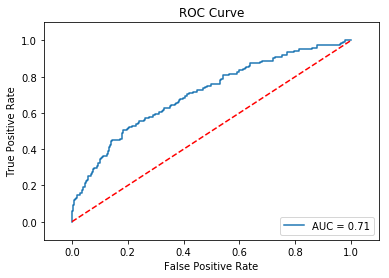

In [186]:
# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

In [204]:
from sklearn.ensemble import RandomForestClassifier

In [205]:
clf= RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=10)

In [206]:
clf.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [207]:
predictions=clf.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))

[[424  39]
 [117  34]]


In [208]:
Confusion = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), 
                         index=['NO PTSD','PTSD'], 
                         columns=['NO PTSD','PTSD'])
Confusion

accuracy = accuracy_score(y_test, predictions)
accuracy

0.745928338762215

In [209]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=2)


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [210]:
y_preds = clf.predict_proba(X_test)

# take the second column because the classifier outputs scores for
# the 0 class as well
preds = y_preds[:,1]
import matplotlib.pyplot as plt

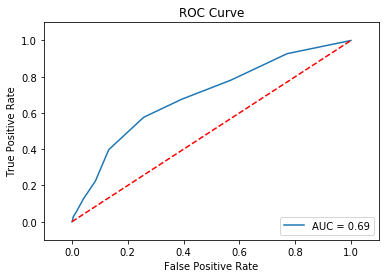

In [211]:
# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

In [212]:
#Naive bayes doesnt work well

from sklearn.naive_bayes import GaussianNB

In [213]:
clf=GaussianNB()

In [215]:
clf.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

In [216]:
predictions=clf.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))

[[153 310]
 [ 22 129]]


In [217]:
Confusion = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), 
                         index=['NO PTSD','PTSD'], 
                         columns=['NO PTSD','PTSD'])
Confusion

accuracy = accuracy_score(y_test, predictions)
accuracy

0.4592833876221498

In [218]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=2)



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [219]:
y_preds = clf.predict_proba(X_test)

# take the second column because the classifier outputs scores for
# the 0 class as well
preds = y_preds[:,1]
import matplotlib.pyplot as plt

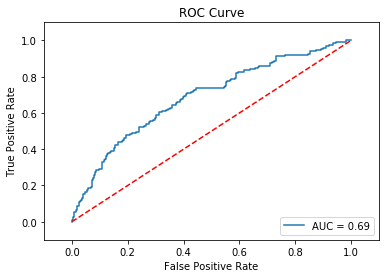

In [220]:
# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()